<h1>Tiefe neuronale Netze</h1>

In diesem Übungsblatt lernst du

<ul>
    <li>was tiefe neuronale Netze sind und wie man diese implementiert,</li>
    <li>wie Bilder (oder andere Daten) von der KI intepretiert werden und wie die KI Bilder klassifiziert,</li>
    <li>die Wichtigkeit einer nicht-linearen Aktivierungsfunktion,</li>
    <li>was ein <i>Convolutional Neural Network (CNN)</i> ist und</li>
    <li>wie ein Lernprozess eines neuronales Netzes umgesetzt wird.</li>
</ul>

Du solltest bereits

<ul>
    <li>die grobe Idee von neuronalen Netzen und deren Ausgabe verstehen,</li>
    <li>wissen, was Neuronen, Gewichte und Aktivierungsfunktionen und eine Loss-Funktion sind,</li>
    <li>nachvollziehen können, wie die Gewichte in einem neuronalen Netz angepasst werden (Backpropagation) und</li>
    <li>mit Tensoren aus der Bibliothek <i>PyTorch</i> umgehen können.</li>
</ul>

Importiere zunächst alle notwendigen Bibliotheken für dieses Jupyter Notebook, indem du das untere Codefeld ausführst. Beachte, dass du bei jedem Neustart des Kernels auch das untere Codefeld jedes Mal ausführen musst.

In [16]:
# Führe dieses Feld aus, indem du entweder oben auf 'Run' klickst oder 'Strg + Enter' drückst.
import torch 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from copy import deepcopy

<h2>Was sind tiefe neuronale Netze?</h2>

Bis jetzt hast du gelernt, dass ein neuronales Netz aus einer Eingabeschicht (engl. <i>input layer</i>), einer Ausgabeschicht (engl. <i>output layer</i>) und einer Schicht zwischen der Eingabe- und Ausgabeschicht besteht. Die dazwischenliegende Schicht bezeichnet man als <i>hidden layer</i>. Hat ein neuronales Netz eine ausreichend große Anzahl an <i>hidden layers</i>, so wird es als <b>tiefes neuronales Netz</b> (engl. <i><b>deep neural network</b></i>) bezeichnet. 

&nbsp;


 <figure>
  <img src="img/deep_neural_network.webp" alt="Deep Neural Network" style="width:50%">
  <figcaption></figcaption>
</figure> 

&nbsp;

In der Grafik siehst du, dass die Neuronen einer beliebigen Schicht mit allen Neuronen der nachfolgenden Schicht verbunden sind. Solche Schichten, die vollständig mit der nachfolgenden Schicht verbunden sind, bezeichnet man als <i><b>fully-connected layer</b></i>. Da dieses neuronale Netz nur aus solchen Schichten besteht, nennt man so ein Netz auch <i>Fully Connected Neural Network</i>.

Im Folgenden möchten wir so ein Netz mithilfe von <i>PyTorch</i> umsetzen, um es mithilfe von selbst generierten Daten trainieren zu lassen. 

____


<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Ergänze die folgende Klasse, indem du drei vollständig verbundene Schichten im Konstruktur der Klasse einfügst. Die Anzahl der Neuronen der Eingabe- und Ausgabeschichten werden dabei als Parameter angegeben. Die versteckte Schicht soll fünf Neuronen enthalten. Die Funktion 'forward' brauchst du vorerst nicht zu beachten.</i>

In [2]:
# Eine Beispielschicht mit 3 Eingängen und 4 Ausgaben.
schicht_beispiel = nn.Linear(3, 4)

class Net(torch.nn.Module):

    def __init__(self, num_in, num_out):
        super(Net, self).__init__()
        self.name_model = "Net"
        self.fc1 = nn.Linear(num_in, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, num_out)
        
        self.relu=torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    # Neuronales Netz ohne ReLU-Funktion
    '''
    def forward(self, x):
        
        output = self.fc1(x)
        output = self.fc2(output)
        output = self.softmax(self.fc3(output))
        return output
    '''
    
    # Neuronales Netz mit ReLU-Funktion
    
    def forward(self, x):
        
        output = self.relu(self.fc1(x))
        output = self.relu(self.fc2(output))
        output = self.softmax(self.fc3(output))
        return output

Als Nächstes möchten wir dieses Netz eine bestimmte Aufgabe trainieren lassen. Zunächst schauen wir uns aber an, was Daten bzw. in unserem speziellen Fall Bilder für den Computer eigentlich sind.

<h3>Codierung von Bildern</h3>

Farben werden im Computer als Zahlenwerte codiert. Die gebräuchlichste Codierungsmethode ist dabei die <b>RGB-Codierung</b>, bei der jede Farbe eine Mischung der drei Farbkanäle rot, grün und blau ist, deren Werte jeweils im Zahlenbereich 0 bis 255 liegen, also 8 Bit groß sind (bspw. kodiert das Tripel (255, 128, 0) die Farbe Orange). Für ein buntes Bild müssen also pro Pixel drei Zahlenwerte gespeichert werden.  

&nbsp;


 <figure>
  <img src="img/lincoln_pixels.png" alt="Abraham Lincoln Pixels" style="width:50%">
  <figcaption></figcaption>
</figure> 

&nbsp;

Bei Schwarz-weiß Bildern wird dagegen nur ein Zahlenwert pro Pixel gespeichert. Der Zahlenwert 0 entspricht dabei einem komplett schwarzen Pixel, während der Wert 255 einem weißen Pixel entspricht. Zahlenwerte zwischen 0 und 255 entsprechen unterschiedlichen Graustufen. 

Bilder sind zusammgesetzte Pixel und für den Computer somit einfach nur Listen aus Zahlen, die sich als Eingaben für ein neuronales Netz eignen. Die Anzahl der Pixel muss dabei der Anzahl der Neuronen der Eingabeschicht entsprechen.

Um die Komplexität im Folgenden soweit wie möglich zu reduzieren, betrachten wir Graustufenbilder, die nur aus wenigen Pixel bestehen. Ein Bild, das nur aus einem Pixel besteht, können wir als Punkt in einem eindimensionalen Koordinatensystem markieren. Ein Bild aus zwei Pixeln ist ein Punkt im zweidimensionalen Koordinatensytem. 

____

<i class="fa-solid fa-eye" style="font-size:38px"></i>

<i>Führe das untere Feld aus. Du siehst drei zwei Pixel große Bilder, die durch die Zahlenwerte (50, 120), (150, 210) und (200, 100) codiert werden.</i>

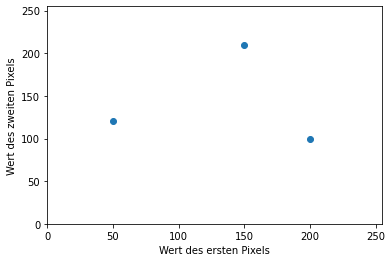

In [3]:
plt.scatter([50, 150, 200], [120, 210, 100])
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.xlabel("Wert des ersten Pixels")
plt.ylabel("Wert des zweiten Pixels")
plt.show()

Drei Pixel große Bilder sind also Punkte im dreidimensionalen Raum und <i>n</i> Pixel große <b>Bilder</b> (für <i>n</i> > 3) sind <b>Punkte in einem <i>n</i>-dimensionalen Raum</b>, die unsere Vorstellung weit übersteigen.

Was macht nun ein neuronales Netz? Wie unterscheidet ein neuronales Netz eine Katze von einem Hund? Diesen Fragen widmen wir uns im nächsten Abschnitt.

<h3>Neuronales Netz mit Datenpunkten trainieren lassen</h3>

Wir betrachten in diesem Abschnitt nur zwei Pixel große Bilder und sehen davon ab, dass sie nur Werte im Bereich von 0 bis 255 annehmen können.

____


<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Implementiere eine Funktion, die als Parameter die x- und y-Koordinate eines Punktes erhält und '0' zurückgibt, wenn die y-Koordinate größer oder gleich der x-Koordinate ist und '1', wenn das nich der Fall ist. </i>

In [4]:

def f(x,y):
    if y >= x:
        return torch.tensor([0], dtype=int)
    else:
        return torch.tensor([1], dtype=int)

'''
def f(x,y):
    if y >= 1/2 * x * x - 20:
        return torch.tensor([0], dtype=int)
    else:
        return torch.tensor([1], dtype=int)
'''

'\ndef f(x,y):\n    if y >= 1/2 * x * x - 20:\n        return torch.tensor([0], dtype=int)\n    else:\n        return torch.tensor([1], dtype=int)\n'

____


<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Erzeuge nun 500 zufällige zweidimensionale Punkte und visualisiere sie mit Hilfe von Pyplot. Ein Punkt, dessen x- und y-Koordinaten eingesetzt in die gerade implementierte Funktion '0' ergibt, gehört zur 1. Kategorie und soll dabei blau eingefärbt werden. Ein Punkt, dessen Koordinaten das Ergebnis '1' liefern, gehört zur 2. Kategorie und soll rot eingefärbt werden.</i>

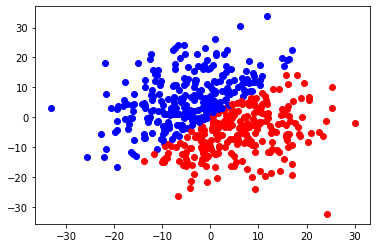

In [5]:
# Trainingsdaten
train_data = torch.randn(500, 2) * 10 
train_visualize = train_data.numpy()

x = train_visualize[:, :1]
y = train_visualize[:, 1:]

list1 = []
for idx, a in enumerate(x):
    if f(a, y[idx]) == 0:
        plt.scatter([a], [y[idx]], color="blue")
    else:
        plt.scatter([a], [y[idx]], color="red")

plt.show()

Nun möchten wir einen Punkt als Eingabe in unser neuronales Netz einsetzen und eine Ausgabe bekommen. Dafür müssen wir in unserem Netz die Methode <i>forward</i> implementieren. In dieser Methode geben wir an, wie die Eingabe Layer für Layer verarbeitet wird.

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Implementiere oben in deinem neuronalen Netz die Methode 'forward'. Die Eingabe des ersten Layers entspricht dabei dem Parameter 'num_in', die Eingabe des zweiten Layers der Ausgabe des ersten Layers usw. Die Methode soll die Ausgabe der letzten Schicht in Prozent zurückgeben. (Du brauchst zunächst keine Aktivierungsfunktion zu verwenden.)</i>

<h3>Trainieren und testen</h3>

Jetzt sind wir bereit unser neuronales Netz zu trainieren. Wir haben bereits oben unsere Trainingsdaten erzeugt. Jetzt müssen wir diesen Daten noch labeln, d.h. der entsprechenden Klasse zuweisen. Dieser Prozess ist normalerweise sehr aufwendig, weil ein oder sogar mehrere Menschen sich die Daten durchsehen und der entsprechenden Kategorie zuweisen müssen (du hast das bestimmt auch schon einmal unfreiwillig bei einer Captcha gemacht). Für unseren Fall können wir aber für das Labeln die uns bekannte Funktion benutzen, die das neuronale Netz erlernen soll. 

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Erzeuge einen Tensor, dessen Einträge die entsprechenden Labels der Datenpunkte sind.</i>

In [6]:
train_labels = torch.tensor([], dtype=int)
for x in train_data:
    y = f(x[0],x[1])
    train_labels = torch.cat((train_labels, y), 0)

Wir haben also nun Trainingsdaten erzeugt. Um ein zufriedenstellendes Training zu gewährleisten, brauchen wir allerdings noch Testdaten, die sich jeweils von den Trainingsdaten <b>unterscheiden</b>.

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Erzeuge 50 Testdatenpunkte und label sie entsprechend der Funktion wie bei den Trainingsdaten.</i>

In [7]:
test_data = torch.randn(50, 2) * 10
test_labels = torch.tensor([], dtype=int)
for x in test_data:
    y = f(x[0],x[1])
    test_labels = torch.cat((test_labels, y), 0)

____

<i class="fa-solid fa-eye" style="font-size:38px"></i>

<i>Versuche die Idee der Implementierung der Trainingsmethode zu verstehen. Erzeuge eine Instanz von deinem neuronalen Netz und übergebe der Trainingsmethode dein Modell. Lass dir dabei mit der 'print'-Funktion die Ausgaben des neuronalen Netzes und die Labels der Datenpunkte ausgeben, um besser nachzuvollziehen, wie das Training abläuft.</i>

In [8]:
def train(model, train_data, train_labels, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.train(True)
    optimizer.zero_grad()

    outputs = model(train_data)
    # print("outputs=", outputs)
    # print("labels=", y)
    # print("max(outputs)=", torch.argmax(outputs, 1))

    loss = loss_fn(outputs, train_labels)
    loss.backward()
    optimizer.step()
    # print("Loss=", loss)

Um zu beurteilen, wie gut das neuronale Netz lernt, betrachten wir die <b>Loss-Funktion</b>. Die Loss-Funktion gibt uns an, wie weit die Ausgaben des neuronalen Netzes von den richtigen Labels abweichen. Je kleiner der entsprechende Wert der Loss-Funktion für ein bestimmte Eingabe, desto besser ist die Klassifikation.

&nbsp;

 <figure>
  <img src="img/train_val_loss_landscape.png" alt="Loss-Function" style="width:50%">
  <figcaption></figcaption>
</figure> 

&nbsp;

Ein weiteres Maß zur Bewertung der Güte eines neuronalen Netzes ist die <i><b>Accuracy</b></i>. Die Accuracy gibt in Prozent an, wie viele Daten richtig klassifiziert wurden. 
    
$\text{Accuracy} = \frac{\text{correctly classified}}{\text{total}} $

____

<i style="font-size:38px">?</i>

<i>Auf welchen Daten muss die Loss-Function und die Accuracy möglichst gut sein? Auf den Trainings- oder Testdaten? Ist die Accuracy immer ein gutes Maß, um die Güte eines neuronalen Netzes zu beurteilen?</i>

&nbsp;
<details>
<summary>➤ Klick hier, um deine Antwort zu prüfen.</summary>
Das Ziel ist es, ein neuronales Netz so zu trainieren, dass es ungesehenen Daten gut klassifizieren kann. Ein geringer Wert der Loss-Funktion und eine hohe Accuracy sind zwar Indizien dafür, dass das neuronale Netz etwas gelernt hat, aber nicht ausreichend dafür, dass es ungesehenen Daten gut klassifiziert. Es kann nämlich sein, dass das Netz die Trainingsdaten auswendig gelernt hat und die Perfomance auf unbekannten Daten sehr schlecht ist.
    
&nbsp;

 <figure>
  <img src="img/overfitting.png" alt="Overfitting" style="width:40%">
  <figcaption></figcaption>
</figure> 

&nbsp;
    
Es ist also wichtig, das Training rechtzeitig abzubrechen.
    
</details>

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Implementiere eine Testfunktion, die den Wert der Loss-Funktion und der Accuracy auf den Testdaten ausgibt und die den Wert der Loss-Funktion ausgibt.</i>

In [9]:
def test(model, test_data, test_labels):
    model.train(False)
    loss_fn = torch.nn.CrossEntropyLoss()
    outputs = model(test_data)
    loss = loss_fn(outputs, test_labels)
    # print("Loss=", loss)
    correctly_classified = 0
    for idx, x in enumerate(outputs):
        if torch.argmax(x) == test_labels[idx]:
            correctly_classified += 1
    print(f"{model.name_model} Correctly classified: {correctly_classified} / {outputs.shape[0]}")
    return loss

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Implementiere nun den gesamten Trainingsprozess. Werte dabei nach jeder Epoche die Loss-Funktion und die Accuracy auf den Testdaten aus. Wenn der aktuelle Wert der Loss-Funktion nach 3 Durchläufen nicht wesentlich kleiner ist als der bisher minimale Wertändert, verkleinere die aktuelle Lernrate um den Faktor 10. Speichere dabei immer das Modell mit dem niedrigsten Loss.</i>

In [10]:
def get_model(model):
      return deepcopy(model)

epochs = 20
net = Net(2,2)
lr = 0.1
loss_min = 100000000
counter = 0
best_model = get_model(net)

for i in range(epochs):
    # Training
    train(net, train_data, train_labels, lr)
    # Test
    loss = test(net, test_data, test_labels)
    print(f"Loss={loss}")
    
    # Falls der Loss nach drei Durchläufen nicht wesentlich kleiner wird 
    # als der bisher minimaler Loss, dann wird die Lernrate um den Faktor 
    # 10 verkleinert.
    
    if loss - loss_min > 0.1:
        print("Diff=", loss - loss_min)
        counter += 1
        if counter == 3:
            lr /= 10
            counter = 0
            model = best_model
            print("#### New learning rate", lr)
            
    # Wenn der aktuelle Loss minimal ist, dann wird dieser in der Variablen 
    # 'loss_min' gespeichert und das beste Modell in der Variablen 'best_model'.
    
    else:
        loss_min = loss
        counter = 0
        best_model = get_model(net)

Net Correctly classified: 31 / 50
Loss=0.6211991310119629
Net Correctly classified: 46 / 50
Loss=0.46709057688713074
Net Correctly classified: 45 / 50
Loss=0.4482923150062561
Net Correctly classified: 46 / 50
Loss=0.4159912168979645
Net Correctly classified: 46 / 50
Loss=0.41984280943870544
Net Correctly classified: 45 / 50
Loss=0.4038977026939392
Net Correctly classified: 48 / 50
Loss=0.3718649744987488
Net Correctly classified: 45 / 50
Loss=0.3954025208950043
Net Correctly classified: 49 / 50
Loss=0.357232928276062
Net Correctly classified: 46 / 50
Loss=0.3928709328174591
Net Correctly classified: 49 / 50
Loss=0.3506692945957184
Net Correctly classified: 46 / 50
Loss=0.39212700724601746
Net Correctly classified: 49 / 50
Loss=0.3464348614215851
Net Correctly classified: 46 / 50
Loss=0.39162203669548035
Net Correctly classified: 49 / 50
Loss=0.3394944667816162
Net Correctly classified: 44 / 50
Loss=0.405493825674057
Net Correctly classified: 49 / 50
Loss=0.3390747904777527
Net Correctl

/home/mp/anaconda3/envs/acl/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Ersetze nun deine Funktion durch eine nicht-lineare Funktion (z.B.$f(x) = \frac{1}{2} x^2 - 20$) und lass das Netzwerk noch einmal trainieren. Was beobachtest du?</i>

&nbsp;

<details>
<summary>➤ Klick hier, um fortzufahren.</summary>

Das Netzwerk sollte die Daten nicht mehr mit so einer guten Genauigkeit klassifizieren können, weil die Daten nicht mehr mit Hilfe einer Linie trennbar sind. Das liegt daran, dass keine Aktivierungsfunktion verwendet wird bzw. die Aktivierungsfunktion jeder Schicht des neuronalen Netzes linear ist. 
    
</details>

<h3>Was lernt eigentlich das neuronale Netzwerk beim Training?</h3>

In diesem Abschnitt gehen wir der Frage nach, was das neuronale Netzwerk beim Training eigentlich lernt.

Wie wir wissen sind unterschiedliche Daten (wie z.B. Bilder) n-dimensionale Punkte in einem n-dimensionalem Koordinatensystem. Wenn das Netzwerk nun mit diesen Punkten trainiert wird, lernt es im Laufe des Trainings, welche Punkte zu welcher Klasse gehören und kann im Optimalfall auch ähnliche unbekannte Daten richtig einordnen.

&nbsp;

 <figure>
  <img src="img/layer_sizes.jpeg" alt="2-dimensional space" style="width:25%">
  <figcaption></figcaption>
</figure> 

&nbsp;

<b>Was das Netzwerk also im Grunde genommen lernt, ist eine Trennlinie/-kurve zwischen den Datenpunkten zu ziehen</b>. 

Wenn die Aktivierungsfunktion linear ist, so ist es auch nur möglich linear trennbare Datenpunkte zu separieren. Wenn die Aktvierungsfunktion nicht linear ist, so ist es auch möglich wie in der Grafik Daten mithilfe einer Trennkurve voneinander zu trennen.

Die wahrscheinlich am häufigsten verwendete nicht lineare Funktion in neuronalen Netzen ist die ReLu-Funktion. 

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Füge in der 'forward'-Methode deines neuronalen Netzes nach jeder Ausgabe eines Layers eine ReLu-Funktion hinzu und lasse das Netzwerk erneut auf den Daten, die durch deine nicht-lineare Funktion erzeugt wurden trainieren. Was beobachtest du nun?</i>

____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Zusatzaufgabe: Generiere drei oder mehr Klassen von Datenpunkten mit Hilfe einer von dir gewählten Funktion. Trainiere anschließend ein neuronales Netz, das neue, frei gewählte Datenpunkte (der Funktion entsprechend) deinen gewählten Klassen richtig zuordnet.</i>

<span style="color:blue"><i>Übrigens</i></span>: Die Berechnung der Gradienten bei der Backpropagation erfordern sehr viel Rechenaufwand. Eine CPU wird nur bei kleinen Daten(mengen) gute Ergebnisse in überschaubarer Zeit liefern können. Aus diesem Grund verwendet man GPU-Einheiten (Grafikprozessoren), um ein neuronales Netz trainieren zu lassen. Der Vorteil dieser Verwendung besteht darin, dass die Berechnungen <i>parallel</i> ablaufen können und das Netz somit viel schneller trainiert.

<h2>Convolutionale Neural Networks (CNNs)</h2>

Angenommen du möchtest (relativ große) Bilder mit einem Netzwerk aus Fully-Connected-Layern klassifizieren. 


____

<i style="font-size:38px">?</i>

<i>Eine Schicht hat 64 Neuronen und ist mit einer Schicht aus 100 Neuronen verbunden. Wie viele Gewichte werden zwischen diesen beiden Schichten gelernt?</i>

&nbsp;
<details>
<summary>➤ Klick hier, um deine Antwort zu prüfen.</summary>
64 * 100 = 6400 Gewichte (ohne die Bias-Gewichte) werden gelernt.
    
</details>

Die Anzahl der erlernbaren Gewichten kann in einem Fully-Connected-Netzwerk sehr groß werden und das Lernen u.a. deshalb ineffektiv. Aus diesem Grund hat man sich für die Klassifikation von Bidern eine neue Architektur von neuronalen Netzen überlegt.

<b><i>Convolutional Neural Networks</i></b> (deutsch faltende neuronale Netze) bestehen aus unterschiedlichen Schichten. 


&nbsp;

 <figure>
  <img src="img/cnn.jpeg" alt="CNN" style="width:70%">
  <figcaption></figcaption>
</figure> 

&nbsp;

____

<i class="fa-solid fa-eye" style="font-size:38px"></i>

<i>Schau dir folgendens Video an, um die Idee von CNNs zu verstehen:</i> https://www.youtube.com/watch?v=YRhxdVk_sIs

Die <b>Convolutional Layer</b> bilden den Kern von CNNs. In der Grafik siehst du, was genau in so einem Layer passiert.

&nbsp;

 <figure>
  <img src="img/convlayer.png" alt="CNN" style="width:70%">
  <figcaption></figcaption>
</figure> 

&nbsp;

(Hier ist das Prinziep des Convolutional Layers mit einer Animation dargestellt: https://developers.google.com/machine-learning/glossary/#convolutional_neural_network)

Nach einem Convolutional Layer folgt zumeist ein <b>Max Pooling Layer</b>, der die Informationen reduziert. Die Gewichte von dieser Schicht werden <i>nicht</i> erlernt.

&nbsp;

 <figure>
  <img src="img/max_pooling.png" alt="Max Pooling" style="width:50%">
  <figcaption></figcaption>
</figure> 

&nbsp;





____

<i class="fa fa-laptop" style="font-size:38px"></i>

<i>Implementiere ein Convolutional Neural Network, um die Klassifikation von den gemalten Ostereiern zu umzusetzen. Du findest im Folgenden kleine Codesnippets, die dir helfen sollen diese Aufgabe zu lösen. Zögere nicht, dir von jemandem helfen zu lassen!</i>

In [17]:
import torchvision

# Hier könnte der Pfad zu deinen Daten / die Pfade zu den Ordnern mit den Trainings- und Testbildern stehen.
train_dataset_path = 'DataSet/train'
test_dataset_path = 'DataSet/test'

In [18]:
# Hier könnte die Klasse deines CNNs implementiert sein.
# Folgende Methoden könnten dir dabei helfen.

# Convolutional Layer
intput_channels = 3
output_channels = 6
kernel_size = 5
nn.Conv2d(intput_channels, output_channels, kernel_size)

# Max Pooling Layer
kernel_size_max = 2
nn.MaxPool2d(kernel_size_max, 1)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        # print(x.shape)
        # x = x.view(-1, 16 * 617 * 433)            # -> n, 400
        # x = x.view(-1, 16 * 4 * 4)
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return self.softmax(x)

In [22]:
# Hier werden deine Trainings- und Testdaten in einem Trainloader geladen.
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision 

train_transforms = transforms.Compose([
  transforms.Resize([64,64]),
  transforms.ToTensor()
])

TRAIN_DATA_PATH = '/home/mp/Documents/Hiwi/KICamp2022/Science-Camp-KI/03-EggClassification/Files/SC-KI_2021'

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transforms)
train_loader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [25]:
import tensorflow as tf

bigMess = tf.randomUniform([400, 400, 3], 0, 255); 
tf.node.encodeJpeg(bigMess).then((f) => { 
fs.writeFileSync("simple.jpg", f); 
console.log("Basic JPG 'simple.jpg' written");
  });

SyntaxError: invalid syntax (<ipython-input-25-c5948ec2f9be>, line 4)

In [ ]:
# Hier könntest du deine train- und test-Methoden implementieren.
# Orientiere dich am oberen Code.

# Verwende diesen Optimizer für ein neuronales Netz 'net'
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
# Hier könntest du dein Training umsetzen.
# Nach jeder Epoche solltest du deinen Loss und die Accuracy ausgeben.
# Tipp: Speichere immer das Modell mit dem geringsten durchschnittlichen 
# Loss-Wert als optimales Modell ab. 



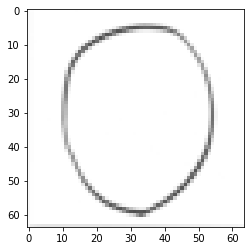

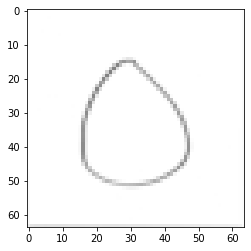

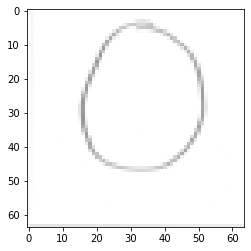

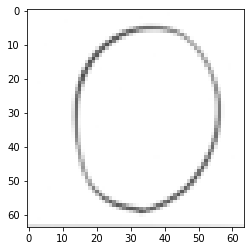

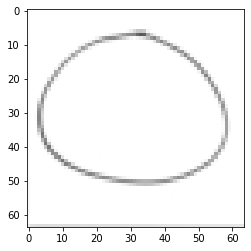

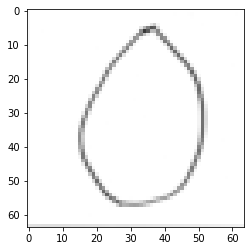

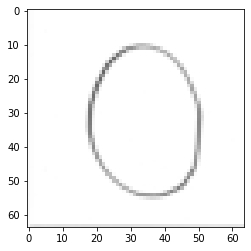

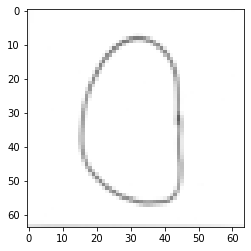

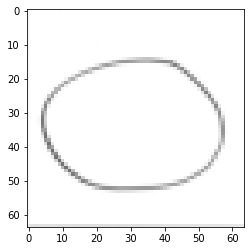

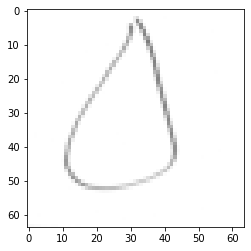

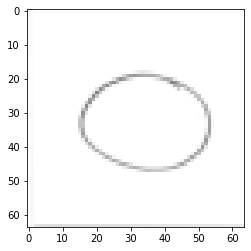

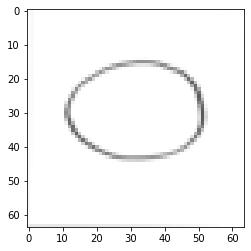

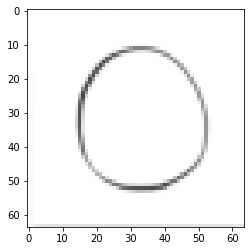

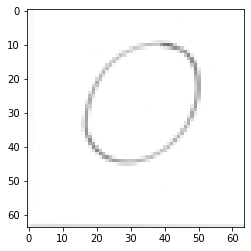

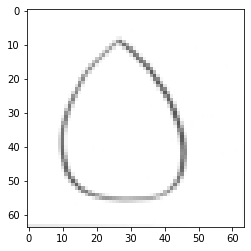

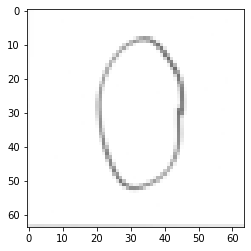

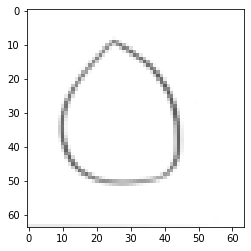

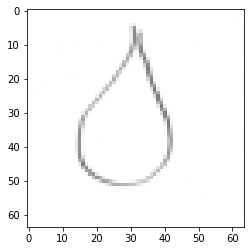

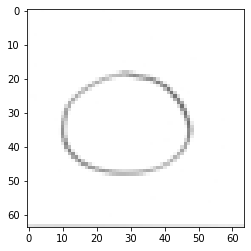

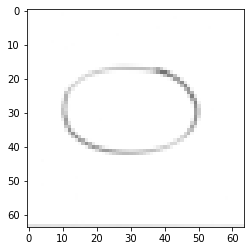

In [26]:
# Mit dieser Methode kannst du dir Bilder deines Trainloaders anzeigen lassen.
# Beschrifte die Bilder zusätzlich mit einem passenden Label.

for x,y in train_loader:
    image = x[0]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.show()

In [27]:
# alexnet = ConvNet()
x = torch.rand(1, 3, 64, 64)
print(x.shape)
# alexnet(x)

def test(model, x, y):
    model.train(False)
    loss_fn = torch.nn.CrossEntropyLoss()
    outputs = model(test_data)
    loss = loss_fn(outputs, test_labels)
    # print("Loss=", loss)
    correctly_classified = 0
    for idx, x in enumerate(outputs):
        if torch.argmax(x) == test_labels[idx]:
            correctly_classified += 1
    print(f"{model.name_model} Correctly classified: {correctly_classified} / {outputs.shape[0]}")

torch.Size([1, 3, 64, 64])


In [34]:
import torch.utils.data as data
import torchvision 
import torchvision.transforms as transforms
import time

# TRAIN_DATA_PATH = './DataSet/train'

train_transforms = transforms.Compose([
  transforms.Resize([64,64]),
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=train_transforms)
train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True)

model = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
num_epochs = 2

def test():
    model.train(False)
    total = 0
    correct = 0
    for x, y in train_loader:
        # print(x.shape)
        # print(y.shape)
        output = model(x)
        # print(output)
        # print(torch.argmax(output))
        if torch.argmax(output) == y:
            correct += 1
        total += 1  
        # print(total)

    print(f"Result: {correct} / {total}")
    
model.train(True)

def train(model, trainloader):
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = torch.nn.CrossEntropyLoss()
    total = 0
    model.train(True)
    for x, y in trainloader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        
        # for p in model.parameters():
        #    print(p)
        total += 1

test()
for i in range(num_epochs):
    
    train(model, train_loader)
    test()

    

/home/mp/anaconda3/envs/acl/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Result: 7 / 307
Result: 210 / 307
Result: 210 / 307


In [ ]:
def train(model, trainloader):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    loss_fn = torch.nn.CrossEntropyLoss()
    total = 0
    model.train(True)
    for x, y in trainloader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        print(f"{total}. {loss}")
        total += 1

<h3>Aktuelle Forschung</h3>

Die Forschung zu neuronalen Netzen ist noch lange nicht ausgeschöpft. Es gibt noch sehr vieles zu entdecken. So wissen wir z.B. immer noch nicht richtig, was genau neuronale Netze eigentlich lernen. 

Wenn du dich für die aktuelle Forschung zu neuronalen Netzen oder KI interessiert, ist folgender YouTube-Kanal empfehlenswert: 

https://www.youtube.com/c/K%C3%A1rolyZsolnai/videos?view=0&sort=p&shelf_id=0

<h2>Bildquellen</h2>

https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_01_03-DeepNeuralNetwork-WHITEBG.png

https://miro.medium.com/max/1386/1*bV7S0zACdidh11ikjYpLpQ.png

https://pyimagesearch.com/wp-content/uploads/2019/10/train_val_loss_landscape.png

https://miro.medium.com/max/1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg

https://anhreynolds.com/img/cnn.png

https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png
